<a href="https://colab.research.google.com/github/juliet29/es159_final/blob/master/extractPaths_orig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
from scipy.spatial import distance

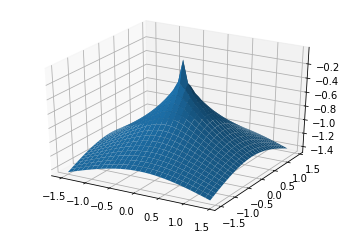

In [289]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
# robot works space
# X = np.arange(-0.5, 0.1, 0.01)
# Y = np.arange(-0.5, 0.5, 0.01)

X = np.arange(-1.5, 1.5, 0.1)
Y = np.arange(-1.5, 1.5, 0.1)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = -np.sqrt(R)

#Plot the surface.
surf = ax.plot_surface(X, Y, Z)

plt.show()

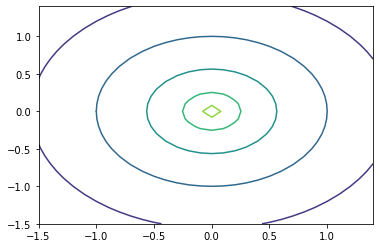

In [290]:
C = plt.contour(X,Y,Z, levels=5)

In [291]:
raw_zs = C.levels
print(C.levels)
raw_df= pd.DataFrame(C.allsegs)
display(raw_df.head(2))

[-1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.  ]


,0,1,2,3
0,None,None,None,None
1,"[[0.4352091887153555, -1.5], [0.50000000000000...","[[-1.5, -0.43520918871535674], [-1.48052472019...","[[1.4000000000000026, 0.693513916207142], [1.3...","[[-0.693513916207142, 1.4000000000000026], [-0..."


In [0]:
# drop dataframe rows that are nan in the first column, and their corresponding zs
mask = raw_df[0].isna()
zs = raw_zs[~mask]
df = raw_df.dropna(subset=[0])

# print(len(zs))
# print(df.shape)

In [0]:
assert(len(zs) == df.shape[0]), 'zs and df do not have same size!'

In [294]:
nice_df = pd.DataFrame(columns=["x", "y", "z"])
for row_n in range(np.shape(df)[0]): 
  df_row = list(df.iloc[row_n].dropna().to_numpy())
  row_z = zs[row_n]
  
  for i in range(len(df_row)):
    row_dict = {}
    row_dict['x'] = [df_row[i][:,0]]
    row_dict['y'] = [df_row[i][:,1]]
    row_dict['z'] = row_z
    row_df = pd.DataFrame(row_dict)
    nice_df = nice_df.append(row_df, ignore_index=True)

display(nice_df.head(2))

,x,y,z
0,"[0.4352091887153555, 0.5000000000000018, 0.600...","[-1.5, -1.480524720191223, -1.4429446828964982...",-1.25
1,"[-1.5, -1.480524720191224, -1.4429446828964994...","[-0.43520918871535674, -0.4999999999999991, -0...",-1.25


In [0]:
def plot_dif_contour(df, z_val):
  z_bool = df['z'] == z_val
  dz = df[z_bool].reset_index(drop=True)
  for i in range(dz.shape[0]):
    ax.plot(dz['x'][i],dz['y'][i], dz['z'][i] +1 )
    # figure out a way to always have z be in between 0 and 1 

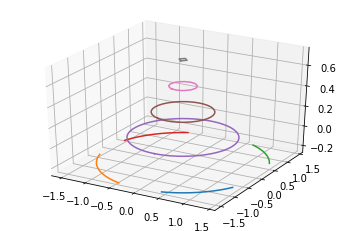

In [296]:
fig = plt.figure()
ax = fig.gca(projection='3d')

for i in zs:
  plot_dif_contour(nice_df, i)

plt.show()


In [0]:
# want to bring all the zs up to the z = 0 level at least 
min_z = nice_df['z'][0]
if min_z < 0:
  nice_df['z'] = nice_df['z'] + abs(min_z)
# display(nice_df.head(2))

In [0]:
# turn into a list of tuples for easy iteration printing 
path = []
# go through all z 
for lev in range(nice_df.shape[0]):
  # all the x,y at a certain z 
  curr_level = nice_df['x'][lev]
  for element in range(len(curr_level)):
    point = (nice_df['x'][lev][element], nice_df['y'][lev][element], nice_df['z'][lev])
    path.append(point)

In [0]:
# turn into a path df for easy manipulation 
path_df = pd.DataFrame(columns=["x", "y", "z"])
path_rows = []
# go through all z 
for lev in range(nice_df.shape[0]):
  # all the x,y at a certain z 
  curr_level = nice_df['x'][lev]
  for element in range(len(curr_level)):
      nu_dict = {'x': nice_df['x'][lev][element], 'y': nice_df['y'][lev][element], 'z': nice_df['z'][lev]}
      path_rows.append(nu_dict)
path_df = pd.DataFrame(path_rows)

# Functions

In [0]:
def findFurthestPoint(df, initPt):
    # initial furthest point is that which is defined by the first row of the df
    furthestPt = df.iloc[0]
    for i in range(df.shape[0]):
        furthest_dist = distance.euclidean(initPt, furthestPt)
        if distance.euclidean(initPt, list(df.iloc[i])) > furthest_dist:
            furthestPt = df.iloc[i]
    return furthestPt

def findClosestPoint(df, initPt):
    "Takes in a dataframe of x,y,z points and a initial point defined as a list [x,y,z], and finds the furthest point in the dataframe from the initial point"
    # initial furthest point is that which is defined by the first row of the df
    closestPt = df.iloc[0]
    for i in range(df.shape[0]):
        closestDist = distance.euclidean(initPt, closestPt)
        # only replace the furthestPt if there is a greater furthest_dist
        if distance.euclidean(initPt, list(df.iloc[i])) < closestDist:
            closestPt = df.iloc[i]
    return closestPt

def midpoint(p1, p2):
    return [np.mean([p1[0], p2[0]]), np.mean([p1[1], p2[1]]), 0]

def boundBox(pos, v):
    "v should be an array of 8 floats"
    x = pos[0]
    y = pos[1]
    # define the vertices of the bounding box
    bb = [(x+v[0], y+v[1], 0),
    (x+v[2], y+v[3], 0),
    (x+v[4], y+v[5], 0),
    (x+v[6], y+v[7], 0)]
    # get the midpoint of the bounding box
    bbC = midpoint(bb[0], bb[2])
    # return a dataframe 
    bbDF = pd.DataFrame(bb, columns=['x','y','z'])
    return (bbDF, bbC)

def boundEdge(bbDF, var):
  n_max = max(bbDF.iloc[:,var])
  n_min = min(bbDF.iloc[:,var])
  return(n_max, n_min)

def pointFilter(df, bb):
  "returns the points inside th bb "
  # points that are less than the max x
  a = df[df['x'] <= boundEdge(bb, 0)[0]]
  # print(a)
  # points that are greater than the min x
  b = a[a['x'] >= boundEdge(bb, 0)[1]]
  # print(b)
  # points that are less than the max y 
  c = b[b['y'] <= boundEdge(bb, 1)[0] ]
  # points that are greater than the min y 
  d = c[c['y'] >= boundEdge(bb, 1)[1] ]
  return d

def execTraj(points):
    "'3D Print' the required joints"
    # calculate the invese kinematics of of a group of points and turn into a list of joint configurations 
    configs = []
    for pos in range(len(points)):
      print(points.iloc[pos])

#Motion Prediction

In [323]:
# df seperate positive and negative y, indices are not reset! 
pos_path_df = path_df.loc[path_df['y'] >= 0]
neg_path_df = path_df.loc[path_df['y'] < 0]
# only want to look at z = 0
zeroDF = pos_path_df.loc[pos_path_df['z'] == 0]
display(zeroDF.head(3))



,x,y,z
41,1.400000,0.693514,0.0
42,1.396948,0.700000,0.0
43,1.342263,0.800000,0.0


In [355]:
for uz in uni_z:
  print(uz)

0.0
0.25
0.5
0.75
1.0


In [0]:
a = 0

done
done
done
done
done


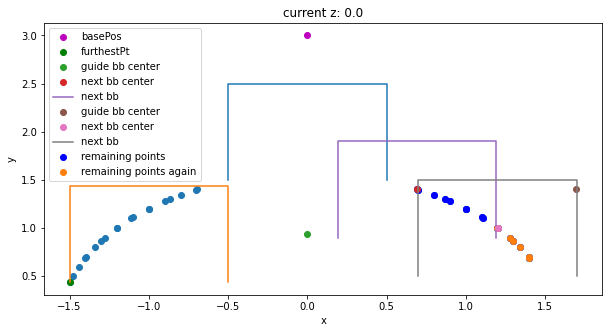

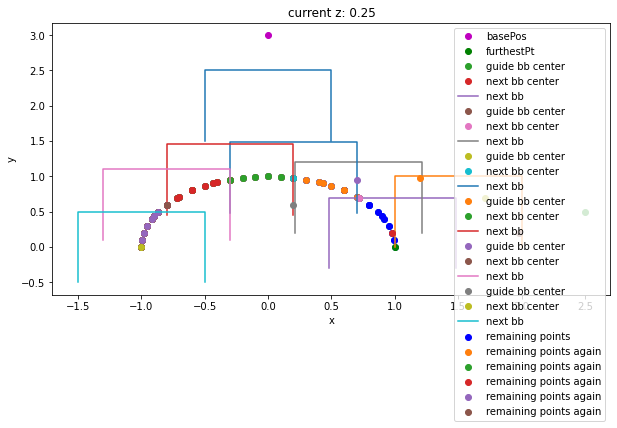

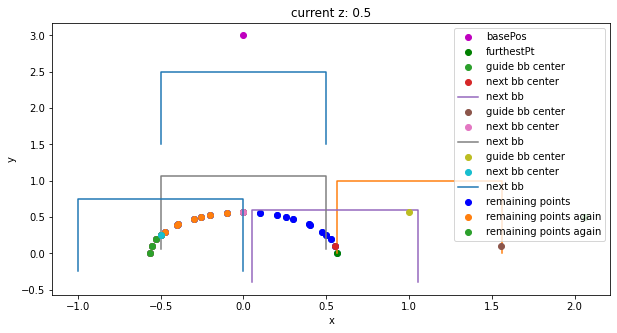

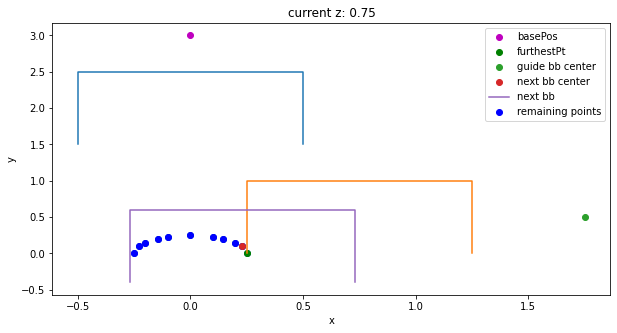

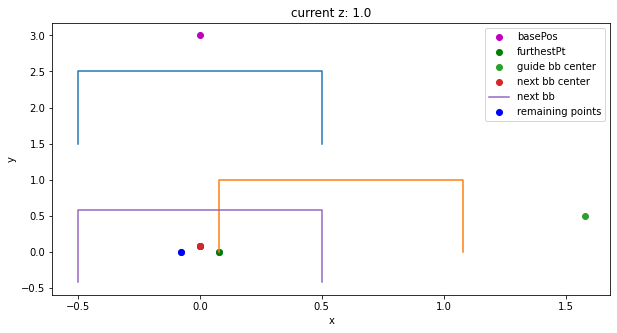

In [356]:
# starting configuration
basePos = [0,3,0]

uni_z = pos_path_df['z'].unique()
# do this for all the zs
for uz in uni_z:
  elevDF = pos_path_df.loc[pos_path_df['z'] == uz]

  fig = plt.figure(figsize=[10,5])
  # geo config at z = 0
  plt.scatter(elevDF['x'], elevDF['y'])
  # base position of robot 
  plt.plot(basePos[0], basePos[1], 'mo', label="basePos")


  # draw the bounding box of the robot 
  vertices = [0.5, -1.5, 0.5, -0.5, -0.5, -0.5, -0.5, -1.5]
  (rBBDF, rBBC) = boundBox(basePos, vertices)
  plt.plot(rBBDF['x'], rBBDF['y'])

  # bb around furthest point of object 
  furthestPt = findFurthestPoint(elevDF, basePos)
  plt.plot(furthestPt[0], furthestPt[1], 'go', label="furthestPt")
  l = 1 # l = length of the bb
  o_vertices = [0,0, 0,l, l,l,l,0]
  (oBBDF, oBBC) = boundBox(furthestPt, o_vertices)
  plt.plot(oBBDF['x'], oBBDF['y'])

  # filter out all the objects in that bounding box oBB
  doneDF = pointFilter(elevDF, oBBDF)
  remainDF = elevDF.copy()
  remainDF = remainDF.drop(doneDF.index)

  # plot the points that remain if they do
  if remainDF.empty:
    break
  else:
    plt.scatter(remainDF['x'], remainDF['y'], color="b", label="remaining points")

  while not remainDF.empty:
    # guess a guide midpoint of the next bounding box
    gBBC = [oBBC[0] + l, oBBC[1], oBBC[2]]
    plt.plot(gBBC[0], gBBC[1], 'o', label="guide bb center")

    # look for the next closest point in the remaining points (guess object 2 bounding box center)
    go2BBC = findClosestPoint(remainDF, gBBC)
    plt.plot(go2BBC[0], go2BBC[1], 'o', label="next bb center")

    # make this the midpoint of the next bb
    l2 = l/2 # half length of the bb 
    o2_vertices = [-l2, -l2, -l2, l2, l2, l2, l2, -l2]
    (oBBDF, oBBC) = boundBox(go2BBC, o2_vertices)
    plt.plot(oBBDF['x'], oBBDF['y'], label="next bb")

    # filter out all the objects in this bb
    doneDF = pointFilter(remainDF, oBBDF)
    remainDF = remainDF.copy()
    remainDF = remainDF.drop(doneDF.index)

    if not remainDF.empty:
      # plot the points that remain
      plt.scatter(remainDF['x'], remainDF['y'], label="remaining points again")
    else:
      print('done')


  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('current z: ' + str(uz))
  plt.legend()



done


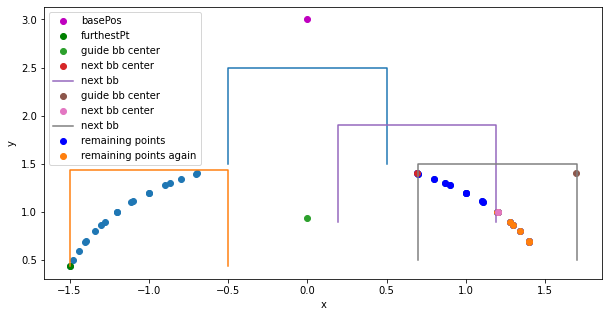

In [338]:
# fig = plt.figure(figsize=[10,5])
# # geo config at z = 0
# plt.scatter(zeroDF['x'], zeroDF['y'])
# # base position of robot 
# plt.plot(basePos[0], basePos[1], 'mo', label="basePos")


# # draw the bounding box of the robot 
# vertices = [0.5, -1.5, 0.5, -0.5, -0.5, -0.5, -0.5, -1.5]
# (rBBDF, rBBC) = boundBox(basePos, vertices)
# plt.plot(rBBDF['x'], rBBDF['y'])

# # bb around furthest point of object 
# furthestPt = findFurthestPoint(zeroDF, basePos)
# plt.plot(furthestPt[0], furthestPt[1], 'go', label="furthestPt")
# l = 1 # l = length of the bb
# o_vertices = [0,0, 0,l, l,l,l,0]
# (oBBDF, oBBC) = boundBox(furthestPt, o_vertices)
# plt.plot(oBBDF['x'], oBBDF['y'])

# # filter out all the objects in that bounding box oBB
# doneDF = pointFilter(zeroDF, oBBDF)
# remainDF = zeroDF.copy()
# remainDF = remainDF.drop(doneDF.index)

# # plot the points that remain
# plt.scatter(remainDF['x'], remainDF['y'], color="b", label="remaining points")

# while not remainDF.empty:
#   # guess a guide midpoint of the next bounding box
#   gBBC = [oBBC[0] + l, oBBC[1], oBBC[2]]
#   plt.plot(gBBC[0], gBBC[1], 'o', label="guide bb center")

#   # look for the next closest point in the remaining points (guess object 2 bounding box center)
#   go2BBC = findClosestPoint(remainDF, gBBC)
#   plt.plot(go2BBC[0], go2BBC[1], 'o', label="next bb center")

#   # make this the midpoint of the next bb
#   l2 = l/2 # half length of the bb 
#   o2_vertices = [-l2, -l2, -l2, l2, l2, l2, l2, -l2]
#   (oBBDF, oBBC) = boundBox(go2BBC, o2_vertices)
#   plt.plot(oBBDF['x'], oBBDF['y'], label="next bb")

#   # filter out all the objects in this bb
#   doneDF = pointFilter(remainDF, oBBDF)
#   remainDF = remainDF.copy()
#   remainDF = remainDF.drop(doneDF.index)

#   if not remainDF.empty:
#     # plot the points that remain
#     plt.scatter(remainDF['x'], remainDF['y'], label="remaining points again")
#   else:
#     print('done')


# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend()

## Old Tins

In [0]:
df_row1 = list(df.iloc[1].dropna().to_numpy())
z1 = zs[1]
x1 = np.concatenate([df_row1[i][:,0] for i in range(len(df_row1))])
y1 = np.concatenate([df_row1[i][:,1] for i in range(len(df_row1))])

In [0]:
df_row2 = list(df.iloc[2].dropna().to_numpy())
z2 = zs[2]
x2 = np.concatenate([df_row2[i][:,0] for i in range(len(df_row2))])
y2 = np.concatenate([df_row2[i][:,1] for i in range(len(df_row2))])

No handles with labels found to put in legend.


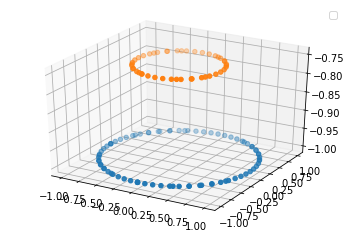

In [308]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(x1, y1, z1)
ax.scatter(x2, y2, z2)
ax.legend()

plt.show()

In [0]:
# plt.plot(df[0][1][:,0],df[0][1][:,1])
# plt.plot(df[1][1][:,0],df[1][1][:,1])
# plt.plot(df[1][1][:,0],df[1][1][:,1])
# plt.plot(df[2][1][:,0],df[2][1][:,1])
# plt.plot(df[3][1][:,0],df[3][1][:,1])
# plt.plot(df[4][1][:,0],df[4][1][:,1])

# plt.plot(df[0][2][:,0],df[0][2][:,1])
# plt.plot(df[4][2][:,0],df[4][2][:,1])

# plt.plot(df[0][3][:,0],df[0][3][:,1])
# plt.plot(df[4][3][:,0],df[4][3][:,1])

# plt.plot(df[0][4][:,0],df[0][4][:,1])
# plt.plot(df[4][4][:,0],df[4][4][:,1])

# plt.plot(df[0][5][:,0],df[0][5][:,1])
# plt.plot(df[5][5][:,0],df[5][5][:,1])

# plt.plot(df[0][6][:,0],df[0][6][:,1])
# plt.plot(df[4][6][:,0],df[4][6][:,1])

# plt.plot(df[0][7][:,0],df[0][7][:,1])
# plt.plot(df[1][7][:,0],df[1][7][:,1])

In [0]:
# this is how to concatenate flat numpy arrays of (n, 1)
#np.concatenate([df_row2[i][:,0] for i in range(len(df_row2))])
